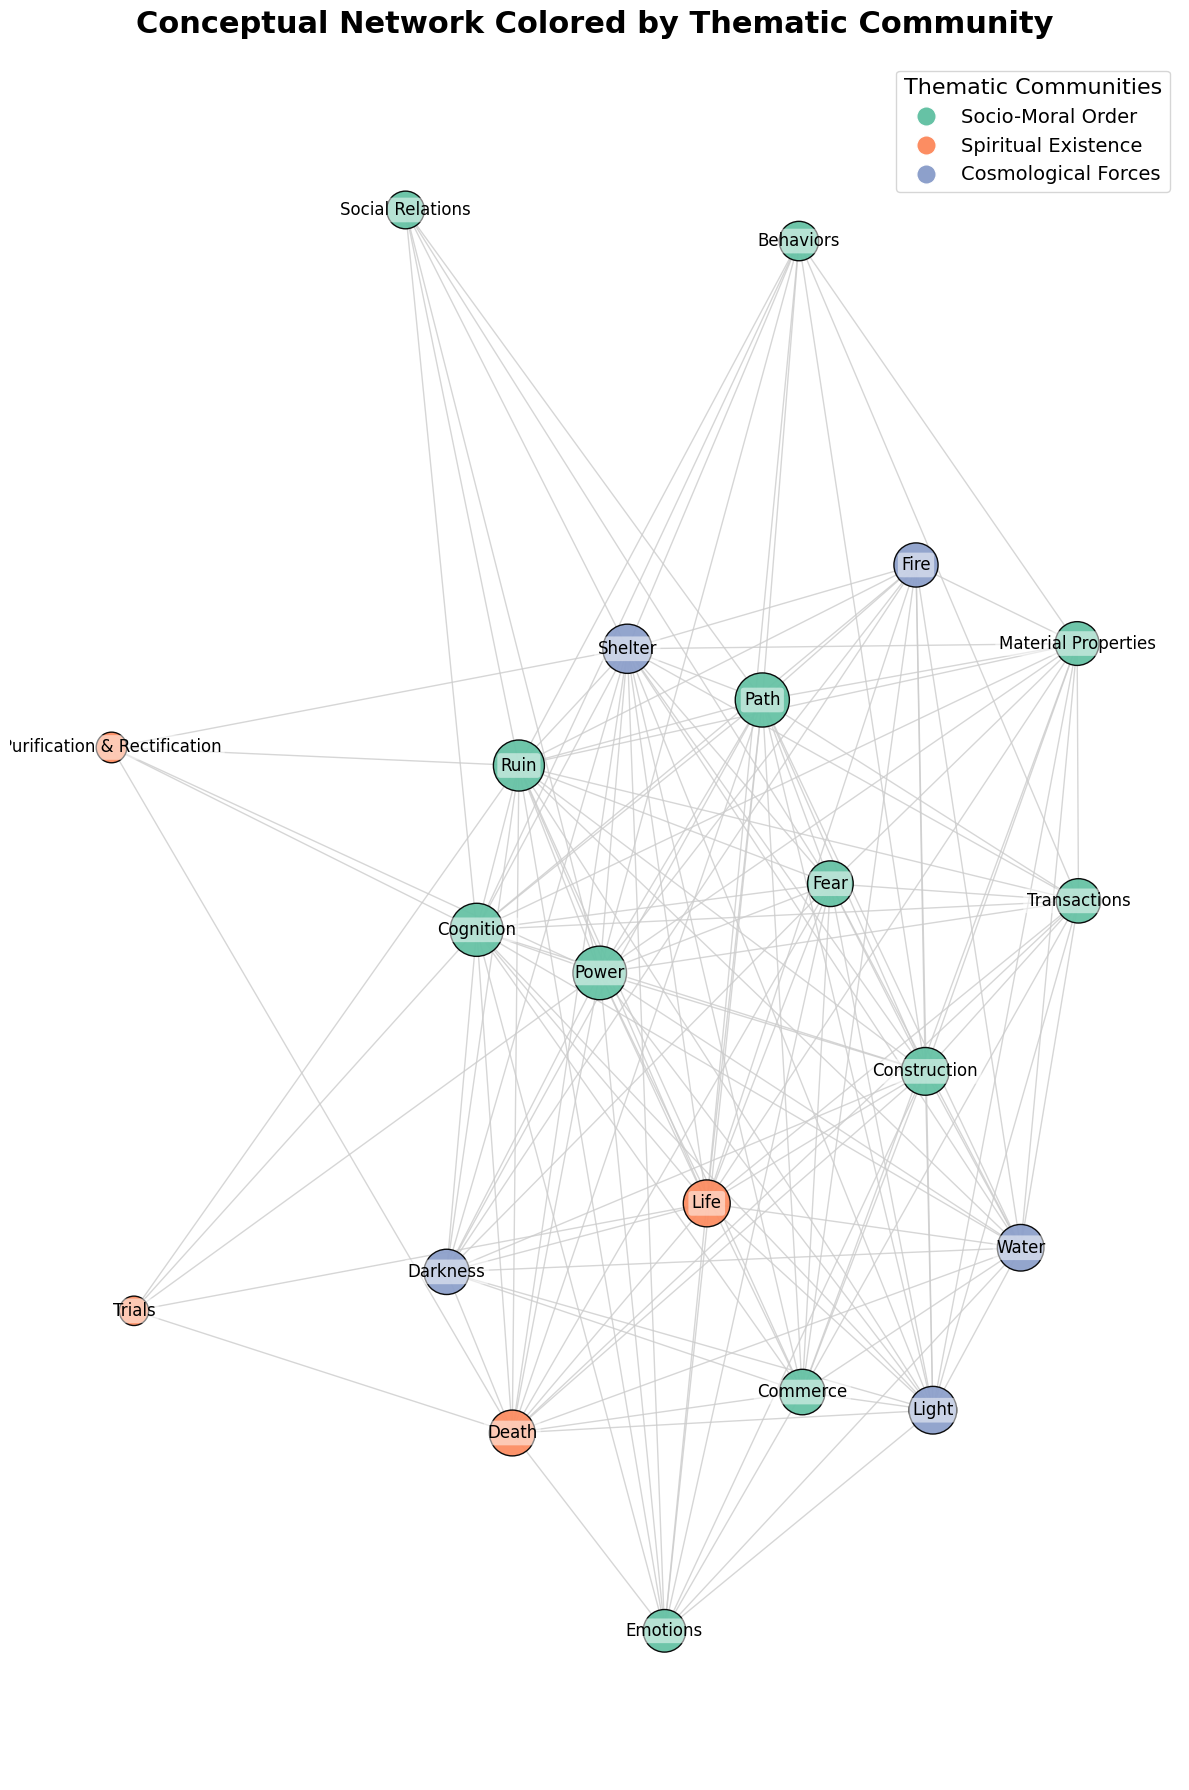


✅ Figure saved successfully: Figure_4a_Vertical_Network_Graphviz.png


In [1]:
# ============================================================
# ✅ Global Network Visualization Colored by Louvain Communities
# ============================================================
#@title  **Global network visualization colored by Louvain communities (node size = weighted degree).**

print("--- [Step 0: Installing Libraries] ---")
!apt-get -qq install -y graphviz libgraphviz-dev pkg-config
!pip uninstall -y community > /dev/null 2>&1
!pip install -qq python-louvain pygraphviz seaborn matplotlib networkx pandas numpy
print("Libraries installed successfully.\n")
!git clone https://github.com/NoorBayan/Amthal.git
%cd Amthal
from utility import *
from IPython.display import display, HTML, clear_output


# --- [الخطوة 1: الاستيراد] ---
print("--- [Step 1: Importing Libraries] ---")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import community.community_louvain as community_louvain
from itertools import combinations
import warnings
import pygraphviz as pgv
from networkx.drawing.nx_agraph import graphviz_layout

# تجاهل التحذيرات غير الضرورية
warnings.simplefilter(action='ignore', category=FutureWarning)
print("Libraries imported successfully.\n")

# --- [الخطوة 2: تحميل وتجهيز البيانات] ---
print("--- [Step 2: Loading and Preparing Data] ---")
INSTANCES_FILE_PATH = '/content/Amthal/data/processed/instances.csv'
try:
    df = pd.read_csv(INSTANCES_FILE_PATH, sep='\t', encoding='utf-16')
    df['Dominant_Concept']=[Dominant_Concept_dic[i]['en'] for i in df.Dominant_Concept]
    df['Valence']=[Valence_dic[i]['ar'] for i in df.Valence]
    df['Revelation_Phase']=[Revelation_Phase_dic[i]['ar'] for i in df.Revelation_Phase]
    df['Abstraction_Level']=[Abstraction_Level_dic[i]['ar'] for i in df.Abstraction_Level]

    print(f"Data loaded successfully. Found {len(df)} instances.\n")
except FileNotFoundError:
    print(f"⚠️ ERROR: File not found at '{INSTANCES_FILE_PATH}'. Please check the path and try again.")
    exit()


# --- [الخطوة 3: بناء الشبكة وتشغيل خوارزمية Louvain] ---
print("--- [Step 3: Building Network and Detecting Communities] ---")
grouped = df.groupby(['Sura_No', 'Aya_No'])['Dominant_Concept'].apply(list)

edges = []
for concepts in grouped:
    if len(concepts) > 1:
        for combo in combinations(set(concepts), 2):
            edges.append(tuple(sorted(combo)))

edge_weights = pd.DataFrame(edges, columns=['source', 'target'])
edge_weights = edge_weights.value_counts().reset_index(name='weight')

# بناء الكائن الشبكي
G = nx.from_pandas_edgelist(edge_weights, 'source', 'target', ['weight'])

# تشغيل خوارزمية Louvain
partition = community_louvain.best_partition(G, weight='weight', resolution=1.0, random_state=42)
num_communities = len(set(partition.values()))
nx.set_node_attributes(G, partition, 'community')
print(f"✅ Found {num_communities} communities based on the partition.\n")


#  ✅  هذا هو الجزء الجديد الذي يطبع البيانات التي أحتاجها


print("--- [START] REQUIRED ANALYTICAL OUTPUT FOR REWRITING SECTION 4.3 ---")

# (1) حساب درجة المعيارية (Modularity Score)
modularity = community_louvain.modularity(partition, G, weight='weight')
print(f"\n--- [1] Modularity Score ---")
print(f"The modularity of the partition is: {modularity:.4f}")

# (2) قائمة المفاهيم في كل مجتمع
communities_dict = {}
for node, comm_id in partition.items():
    if comm_id not in communities_dict:
        communities_dict[comm_id] = []
    communities_dict[comm_id].append(node)

print("\n--- [2] Concepts per Community ---")
for comm_id, nodes in sorted(communities_dict.items()):
    print(f"Community {comm_id}: {sorted(nodes)}")

# (3) أهم المفاهيم في كل مجتمع (حسب درجة المركزية داخل المجتمع)
print("\n--- [3] Most Central Concepts within Each Community ---")
for comm_id in sorted(communities_dict.keys()):
    subgraph_nodes = communities_dict[comm_id]
    subgraph = G.subgraph(subgraph_nodes)

    subgraph_degrees = dict(subgraph.degree(weight='weight'))
    sorted_subgraph_nodes = sorted(subgraph_degrees.items(), key=lambda item: item[1], reverse=True)
    top_nodes_in_subgraph = [node for node, degree in sorted_subgraph_nodes[:4]]

    print(f"Community {comm_id} (Top Hubs): {top_nodes_in_subgraph}")

# (4) الروابط الأقوى بين المجتمعات المختلفة
print("\n--- [4] Strongest Inter-Community Links ---")
inter_community_edges = []
for u, v, weight_dict in G.edges(data=True):
    weight = weight_dict['weight']
    if partition[u] != partition[v]:
        inter_community_edges.append(((u, v), weight, (partition[u], partition[v])))

sorted_inter_edges = sorted(inter_community_edges, key=lambda item: item[1], reverse=True)

print("Top 5 strongest links CONNECTING different communities:")
for edge, weight, comms in sorted_inter_edges[:5]:
    # تأكد من أن ترتيب المجتمعات ثابت للطباعة
    comms_sorted = tuple(sorted(comms))
    print(f"Link: {edge[0]} <--> {edge[1]} (Weight: {weight}) | Connects Community {comms_sorted[0]} and {comms_sorted[1]}")


print("\n--- [END] REQUIRED ANALYTICAL OUTPUT ---")

# --- [الخطوة 4: إعداد الخصائص البصرية] ---
print("\n--- [Step 4: Preparing Visual Properties] ---")
degrees = dict(G.degree(weight='weight'))
node_sizes = [np.log(degrees.get(node, 0) + 1) * 250 for node in G.nodes()]

community_colors = sns.color_palette("Set2", num_communities)
node_colors = [community_colors[partition[node]] for node in G.nodes()]
print("Visual properties prepared.\n")

# --- [الخطوة 5: تحديد مواقع العقد باستخدام Graphviz] ---
print("--- [Step 5: Calculating Layout with Graphviz] ---")
pos = graphviz_layout(G, prog='neato', args='-Gsep=1.5 -Gsplines=true -Goverlap=false')
print("Layout calculated.\n")

# --- [الخطوة 6: الرسم الاحترافي] ---
print("--- [Step 6: Generating Plot] ---")
fig, ax = plt.subplots(figsize=(12, 18), facecolor='white')
ax.set_title('Conceptual Network Colored by Thematic Community',
             fontsize=22, fontweight='bold', pad=20)

nx.draw_networkx_edges(G, pos, width=1.0, edge_color="#cccccc", alpha=0.8, ax=ax)

nodes_viz = nx.draw_networkx_nodes(G, pos, node_size=node_sizes,
                                   node_color=node_colors, alpha=0.95, ax=ax)
nodes_viz.set_edgecolor('black')
nodes_viz.set_linewidth(1.0)

# استخراج التسميات لجميع العقد
labels = {node: node for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=12, font_color='black',
                        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2'))
print("Plot generated.\n")

# --- [الخطوة 7: إضافة أسطورة (Legend)] ---
print("--- [Step 7: Adding Legend] ---")
legend_labels = {
    0: 'Socio-Moral Order',
    1: 'Spiritual Existence',
    2: 'Cosmological Forces'
}
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w',
               label=legend_labels.get(i, f'Community {i+1}'),
               markerfacecolor=color, markersize=14)
    for i, color in enumerate(community_colors)
]

ax.legend(handles=legend_elements, loc='best',
          title="Thematic Communities", fontsize=14, title_fontsize=16)
print("Legend added.\n")

# --- [الخطوة 8: التنسيق النهائي والحفظ] ---
print("--- [Step 8: Finalizing and Saving] ---")
clear_output()
ax.axis('off')
plt.tight_layout()
plt.savefig('Figure_4a_Vertical_Network_Graphviz.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Figure saved successfully: Figure_4a_Vertical_Network_Graphviz.png")